# Imports

In [1]:
import matplotlib.pyplot as plt
from loadfile import *
from phonemes import *
from preprocess import *
from evaluate import *
from google_kb_z_speaker.main import *
from tqdm.auto import tqdm
from experiment_helpers import *
from functools import partial
import numpy as np
import logging
from seqmatch import *
from main import *
from google_kb_z_speaker.experiments import *
from google_kb_z_speaker.preprocessing import *
import pickle
import random
import shutil 
import codecs

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Text processing

In [2]:
def convert_iso_to_utf(sourceFileName):
    BLOCKSIZE = 1048576  # or some other, desired size in bytes
    with codecs.open(sourceFileName, "r", "ISO-8859-1") as sourceFile:
        with codecs.open(sourceFileName + ".converted", "w", "utf-8") as targetFile:
            while True:
                contents = sourceFile.read(BLOCKSIZE)
                if not contents:
                    break
                targetFile.write(contents)
    shutil.move(sourceFileName + ".converted", sourceFileName)

In [17]:
read_speech_dir = "/data/sisters/maggan_read"
dialogue_speech_dir = "/data/sisters/maggan_dialogue"
curr_speech_dir = read_speech_dir
speech_type = os.path.basename(curr_speech_dir)

# Clean previous output
shutil.rmtree(os.path.join("output", speech_type))
shutil.rmtree(os.path.join("transcriptions", speech_type))
os.mkdir(os.path.join("output", speech_type))
os.mkdir(os.path.join("transcriptions", speech_type))

In [18]:
speaker_paths = [ os.path.join(curr_speech_dir, x) for x in os.listdir(curr_speech_dir) if x.startswith("z")]

In [19]:
# Copy files from /data/ to output dir and convert to UTF8
for sp in speaker_paths:
    for x in os.listdir(sp):
        if "google" in x:
            shutil.copy(os.path.join(sp,x), os.path.join("output",speech_type,x))
            if speech_type == "maggan_dialogue":
                convert_iso_to_utf( os.path.join("output",speech_type,x))
        if "correct" in x:
            shutil.copy(os.path.join(sp,x), os.path.join("output",speech_type,x))
            convert_iso_to_utf( os.path.join("output",speech_type,x))

'output/maggan_read/z12.googleasr'

'output/maggan_read/z12.correct'

'output/maggan_read/z3.googleasr'

'output/maggan_read/z3.correct'

'output/maggan_read/z7.googleasr'

'output/maggan_read/z7.correct'

'output/maggan_read/z26.correct'

'output/maggan_read/z26.googleasr'

'output/maggan_read/z6.correct'

'output/maggan_read/z6.googleasr'

'output/maggan_read/z17.correct'

'output/maggan_read/z17.googleasr'

'output/maggan_read/z22.googleasr'

'output/maggan_read/z22.correct'

'output/maggan_read/z25.googleasr'

'output/maggan_read/z25.correct'

'output/maggan_read/z14.googleasr'

'output/maggan_read/z14.correct'

'output/maggan_read/z8.googleasr'

'output/maggan_read/z8.correct'

'output/maggan_read/z5.googleasr'

'output/maggan_read/z5.correct'

'output/maggan_read/z18.correct'

'output/maggan_read/z18.googleasr'

'output/maggan_read/z15.googleasr'

'output/maggan_read/z15.correct'

'output/maggan_read/z23.googleasr'

'output/maggan_read/z23.correct'

'output/maggan_read/z16.googleasr'

'output/maggan_read/z16.correct'

'output/maggan_read/z13.correct'

'output/maggan_read/z13.googleasr'

'output/maggan_read/z9.correct'

'output/maggan_read/z9.googleasr'

In [20]:
!file ./output/maggan_read/* | grep ISO

./output/maggan_read/z16.googleasr: ISO-8859 text
./output/maggan_read/z17.googleasr: ISO-8859 text
./output/maggan_read/z18.googleasr: ISO-8859 text
./output/maggan_read/z22.googleasr: ISO-8859 text
./output/maggan_read/z23.googleasr: ISO-8859 text
./output/maggan_read/z25.googleasr: ISO-8859 text
./output/maggan_read/z26.googleasr: ISO-8859 text
./output/maggan_read/z3.googleasr:  ISO-8859 text
./output/maggan_read/z5.googleasr:  ISO-8859 text
./output/maggan_read/z6.googleasr:  ISO-8859 text
./output/maggan_read/z7.googleasr:  ISO-8859 text


In [21]:
iso_speakers = ["z16", "z17", "z18", "z22", "z23", "z25", "z26", "z3", "z5", "z6", "z7"]

In [22]:
# Some maggan read files are iso-8859 # Not idempotent
if speech_type == "maggan_read":
    for filename in os.listdir(os.path.join("output", speech_type)):
        for speaker in iso_speakers:
            if speaker in filename and "google" in filename:
                print(f"Converting {speaker} in filename {filename}")
                convert_iso_to_utf( os.path.join("output",speech_type,filename))

Converting z22 in filename z22.googleasr
Converting z5 in filename z5.googleasr
Converting z7 in filename z7.googleasr
Converting z16 in filename z16.googleasr
Converting z23 in filename z23.googleasr
Converting z18 in filename z18.googleasr
Converting z3 in filename z3.googleasr
Converting z17 in filename z17.googleasr
Converting z25 in filename z25.googleasr
Converting z26 in filename z26.googleasr
Converting z6 in filename z6.googleasr


## Transcribe directory of speakers

In [23]:
models = [
    "KBLab/wav2vec2-large-voxrex-swedish",
        "birgermoell/lm-swedish"
]
for d in tqdm(speaker_paths):
    speaker_name = os.path.basename(d)
    output_path = os.path.join("output",speech_type, speaker_name + ".kb")
    print(f"Transcribing {speaker_name} with output path {output_path}")
    transcribe_directory_of_wav_files(d, output_path, model_type="birgermoell/lm-swedish")

  0%|          | 0/17 [00:00<?, ?it/s]

Transcribing z12 with output path output/maggan_read/z12.kb


  0%|          | 0/273 [00:00<?, ?it/s]

2022-03-23 13:10:00,429.429 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443


Transcribing file  /data/sisters/maggan_read/z12/file_112.wav
Using model  birgermoell/lm-swedish


2022-03-23 13:10:00,917.917 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2022-03-23 13:10:00,920.920 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:10:01,403.403 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-23 13:10:01,414.414 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:10:01,911.911 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-23 13:10:01,917.917 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:10:02,406.406 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/vocab.json HTTP/1.1" 200 0
2022-03-23 13:10:02,413.413 DEBUG connectionpool:  Starti

Transcribing file  /data/sisters/maggan_read/z12/file_127.wav
Transcribing file  /data/sisters/maggan_read/z12/file_133.wav
Transcribing file  /data/sisters/maggan_read/z12/file_11.wav
Transcribing file  /data/sisters/maggan_read/z12/file_46.wav
Transcribing file  /data/sisters/maggan_read/z12/file_27.wav
Transcribing file  /data/sisters/maggan_read/z12/file_71.wav
Transcribing file  /data/sisters/maggan_read/z12/file_56.wav
Transcribing file  /data/sisters/maggan_read/z12/file_102.wav
Transcribing file  /data/sisters/maggan_read/z12/file_78.wav
Transcribing file  /data/sisters/maggan_read/z12/file_10.wav
Transcribing file  /data/sisters/maggan_read/z12/file_62.wav
Transcribing file  /data/sisters/maggan_read/z12/file_45.wav
Transcribing file  /data/sisters/maggan_read/z12/file_120.wav
Transcribing file  /data/sisters/maggan_read/z12/file_23.wav
Transcribing file  /data/sisters/maggan_read/z12/file_13.wav
Transcribing file  /data/sisters/maggan_read/z12/file_2.wav
Transcribing file  /d

  0%|          | 0/93 [00:00<?, ?it/s]

2022-03-23 13:10:11,042.42 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443


Transcribing file  /data/sisters/maggan_read/z3/file_11.wav
Using model  birgermoell/lm-swedish


2022-03-23 13:10:11,528.528 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2022-03-23 13:10:11,539.539 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:10:12,036.36 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-23 13:10:12,044.44 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:10:12,528.528 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-23 13:10:12,536.536 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:10:13,033.33 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/vocab.json HTTP/1.1" 200 0
2022-03-23 13:10:13,041.41 DEBUG connectionpool:  Starting n

Transcribing file  /data/sisters/maggan_read/z3/file_27.wav
Transcribing file  /data/sisters/maggan_read/z3/file_10.wav
Transcribing file  /data/sisters/maggan_read/z3/file_23.wav
Transcribing file  /data/sisters/maggan_read/z3/file_13.wav
Transcribing file  /data/sisters/maggan_read/z3/file_2.wav
Transcribing file  /data/sisters/maggan_read/z3/file_28.wav
Transcribing file  /data/sisters/maggan_read/z3/file_21.wav
Transcribing file  /data/sisters/maggan_read/z3/file_15.wav
Transcribing file  /data/sisters/maggan_read/z3/file_4.wav
Transcribing file  /data/sisters/maggan_read/z3/file_41.wav
Transcribing file  /data/sisters/maggan_read/z3/file_38.wav
Transcribing file  /data/sisters/maggan_read/z3/file_6.wav
Transcribing file  /data/sisters/maggan_read/z3/file_5.wav
Transcribing file  /data/sisters/maggan_read/z3/file_22.wav
Transcribing file  /data/sisters/maggan_read/z3/file_25.wav
Transcribing file  /data/sisters/maggan_read/z3/file_18.wav
Transcribing file  /data/sisters/maggan_read

  0%|          | 0/271 [00:00<?, ?it/s]

2022-03-23 13:10:19,257.257 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443


Transcribing file  /data/sisters/maggan_read/z7/file_112.wav
Using model  birgermoell/lm-swedish


2022-03-23 13:10:19,752.752 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2022-03-23 13:10:19,763.763 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:10:20,273.273 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-23 13:10:20,284.284 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:10:20,781.781 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-23 13:10:20,791.791 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:10:21,293.293 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/vocab.json HTTP/1.1" 200 0
2022-03-23 13:10:21,301.301 DEBUG connectionpool:  Starti

Transcribing file  /data/sisters/maggan_read/z7/file_127.wav
Transcribing file  /data/sisters/maggan_read/z7/file_11.wav
Transcribing file  /data/sisters/maggan_read/z7/file_46.wav
Transcribing file  /data/sisters/maggan_read/z7/file_27.wav
Transcribing file  /data/sisters/maggan_read/z7/file_71.wav
Transcribing file  /data/sisters/maggan_read/z7/file_56.wav
Transcribing file  /data/sisters/maggan_read/z7/file_102.wav
Transcribing file  /data/sisters/maggan_read/z7/file_78.wav
Transcribing file  /data/sisters/maggan_read/z7/file_10.wav
Transcribing file  /data/sisters/maggan_read/z7/file_62.wav
Transcribing file  /data/sisters/maggan_read/z7/file_45.wav
Transcribing file  /data/sisters/maggan_read/z7/file_120.wav
Transcribing file  /data/sisters/maggan_read/z7/file_23.wav
Transcribing file  /data/sisters/maggan_read/z7/file_13.wav
Transcribing file  /data/sisters/maggan_read/z7/file_2.wav
Transcribing file  /data/sisters/maggan_read/z7/file_94.wav
Transcribing file  /data/sisters/magga

  0%|          | 0/505 [00:00<?, ?it/s]

2022-03-23 13:10:28,967.967 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443


Transcribing file  /data/sisters/maggan_read/z26/file_112.wav
Using model  birgermoell/lm-swedish


2022-03-23 13:10:29,465.465 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2022-03-23 13:10:29,472.472 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:10:29,956.956 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-23 13:10:29,964.964 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:10:30,452.452 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-23 13:10:30,460.460 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:10:30,957.957 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/vocab.json HTTP/1.1" 200 0
2022-03-23 13:10:30,965.965 DEBUG connectionpool:  Starti

Transcribing file  /data/sisters/maggan_read/z26/file_127.wav
Transcribing file  /data/sisters/maggan_read/z26/file_133.wav
Transcribing file  /data/sisters/maggan_read/z26/file_135.wav
Transcribing file  /data/sisters/maggan_read/z26/file_11.wav
Transcribing file  /data/sisters/maggan_read/z26/file_46.wav
Transcribing file  /data/sisters/maggan_read/z26/file_209.wav
Transcribing file  /data/sisters/maggan_read/z26/file_27.wav
Transcribing file  /data/sisters/maggan_read/z26/file_71.wav
Transcribing file  /data/sisters/maggan_read/z26/file_56.wav
Transcribing file  /data/sisters/maggan_read/z26/file_193.wav
Transcribing file  /data/sisters/maggan_read/z26/file_207.wav
Transcribing file  /data/sisters/maggan_read/z26/file_192.wav
Transcribing file  /data/sisters/maggan_read/z26/file_102.wav
Transcribing file  /data/sisters/maggan_read/z26/file_164.wav
Transcribing file  /data/sisters/maggan_read/z26/file_171.wav
Transcribing file  /data/sisters/maggan_read/z26/file_175.wav
Transcribing 

  0%|          | 0/121 [00:00<?, ?it/s]

2022-03-23 13:10:40,755.755 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443


Transcribing file  /data/sisters/maggan_read/z6/file_11.wav
Using model  birgermoell/lm-swedish


2022-03-23 13:10:41,252.252 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2022-03-23 13:10:41,263.263 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:10:41,751.751 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-23 13:10:41,762.762 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:10:42,264.264 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-23 13:10:42,272.272 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:10:42,770.770 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/vocab.json HTTP/1.1" 200 0
2022-03-23 13:10:42,778.778 DEBUG connectionpool:  Starti

Transcribing file  /data/sisters/maggan_read/z6/file_46.wav
Transcribing file  /data/sisters/maggan_read/z6/file_27.wav
Transcribing file  /data/sisters/maggan_read/z6/file_56.wav
Transcribing file  /data/sisters/maggan_read/z6/file_10.wav
Transcribing file  /data/sisters/maggan_read/z6/file_45.wav
Transcribing file  /data/sisters/maggan_read/z6/file_23.wav
Transcribing file  /data/sisters/maggan_read/z6/file_13.wav
Transcribing file  /data/sisters/maggan_read/z6/file_2.wav
Transcribing file  /data/sisters/maggan_read/z6/file_28.wav
Transcribing file  /data/sisters/maggan_read/z6/file_49.wav
Transcribing file  /data/sisters/maggan_read/z6/file_54.wav
Transcribing file  /data/sisters/maggan_read/z6/file_50.wav
Transcribing file  /data/sisters/maggan_read/z6/file_21.wav
Transcribing file  /data/sisters/maggan_read/z6/file_15.wav
Transcribing file  /data/sisters/maggan_read/z6/file_4.wav
Transcribing file  /data/sisters/maggan_read/z6/file_41.wav
Transcribing file  /data/sisters/maggan_re

  0%|          | 0/347 [00:00<?, ?it/s]

2022-03-23 13:10:48,984.984 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443


Transcribing file  /data/sisters/maggan_read/z17/file_112.wav
Using model  birgermoell/lm-swedish


2022-03-23 13:10:49,470.470 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2022-03-23 13:10:49,478.478 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:10:49,962.962 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-23 13:10:49,970.970 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:10:50,466.466 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-23 13:10:50,474.474 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:10:50,972.972 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/vocab.json HTTP/1.1" 200 0
2022-03-23 13:10:50,979.979 DEBUG connectionpool:  Starti

Transcribing file  /data/sisters/maggan_read/z17/file_127.wav
Transcribing file  /data/sisters/maggan_read/z17/file_133.wav
Transcribing file  /data/sisters/maggan_read/z17/file_135.wav
Transcribing file  /data/sisters/maggan_read/z17/file_11.wav
Transcribing file  /data/sisters/maggan_read/z17/file_46.wav
Transcribing file  /data/sisters/maggan_read/z17/file_27.wav
Transcribing file  /data/sisters/maggan_read/z17/file_71.wav
Transcribing file  /data/sisters/maggan_read/z17/file_56.wav
Transcribing file  /data/sisters/maggan_read/z17/file_102.wav
Transcribing file  /data/sisters/maggan_read/z17/file_164.wav
Transcribing file  /data/sisters/maggan_read/z17/file_78.wav
Transcribing file  /data/sisters/maggan_read/z17/file_10.wav
Transcribing file  /data/sisters/maggan_read/z17/file_62.wav
Transcribing file  /data/sisters/maggan_read/z17/file_45.wav
Transcribing file  /data/sisters/maggan_read/z17/file_120.wav
Transcribing file  /data/sisters/maggan_read/z17/file_162.wav
Transcribing file

  0%|          | 0/317 [00:00<?, ?it/s]

2022-03-23 13:10:59,639.639 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443


Transcribing file  /data/sisters/maggan_read/z22/file_112.wav
Using model  birgermoell/lm-swedish


2022-03-23 13:11:00,135.135 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2022-03-23 13:11:00,144.144 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:11:00,628.628 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-23 13:11:00,631.631 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:11:01,119.119 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-23 13:11:01,130.130 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:11:01,625.625 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/vocab.json HTTP/1.1" 200 0
2022-03-23 13:11:01,632.632 DEBUG connectionpool:  Starti

Transcribing file  /data/sisters/maggan_read/z22/file_127.wav
Transcribing file  /data/sisters/maggan_read/z22/file_133.wav
Transcribing file  /data/sisters/maggan_read/z22/file_135.wav
Transcribing file  /data/sisters/maggan_read/z22/file_11.wav
Transcribing file  /data/sisters/maggan_read/z22/file_46.wav
Transcribing file  /data/sisters/maggan_read/z22/file_27.wav
Transcribing file  /data/sisters/maggan_read/z22/file_71.wav
Transcribing file  /data/sisters/maggan_read/z22/file_56.wav
Transcribing file  /data/sisters/maggan_read/z22/file_102.wav
Transcribing file  /data/sisters/maggan_read/z22/file_78.wav
Transcribing file  /data/sisters/maggan_read/z22/file_10.wav
Transcribing file  /data/sisters/maggan_read/z22/file_62.wav
Transcribing file  /data/sisters/maggan_read/z22/file_45.wav
Transcribing file  /data/sisters/maggan_read/z22/file_120.wav
Transcribing file  /data/sisters/maggan_read/z22/file_23.wav
Transcribing file  /data/sisters/maggan_read/z22/file_13.wav
Transcribing file  

  0%|          | 0/317 [00:00<?, ?it/s]

2022-03-23 13:11:09,916.916 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443


Transcribing file  /data/sisters/maggan_read/z25/file_112.wav
Using model  birgermoell/lm-swedish


2022-03-23 13:11:10,410.410 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2022-03-23 13:11:10,421.421 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:11:10,902.902 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-23 13:11:10,910.910 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:11:11,391.391 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-23 13:11:11,399.399 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:11:11,895.895 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/vocab.json HTTP/1.1" 200 0
2022-03-23 13:11:11,903.903 DEBUG connectionpool:  Starti

Transcribing file  /data/sisters/maggan_read/z25/file_127.wav
Transcribing file  /data/sisters/maggan_read/z25/file_133.wav
Transcribing file  /data/sisters/maggan_read/z25/file_135.wav
Transcribing file  /data/sisters/maggan_read/z25/file_11.wav
Transcribing file  /data/sisters/maggan_read/z25/file_46.wav
Transcribing file  /data/sisters/maggan_read/z25/file_27.wav
Transcribing file  /data/sisters/maggan_read/z25/file_71.wav
Transcribing file  /data/sisters/maggan_read/z25/file_56.wav
Transcribing file  /data/sisters/maggan_read/z25/file_102.wav
Transcribing file  /data/sisters/maggan_read/z25/file_78.wav
Transcribing file  /data/sisters/maggan_read/z25/file_10.wav
Transcribing file  /data/sisters/maggan_read/z25/file_62.wav
Transcribing file  /data/sisters/maggan_read/z25/file_45.wav
Transcribing file  /data/sisters/maggan_read/z25/file_120.wav
Transcribing file  /data/sisters/maggan_read/z25/file_23.wav
Transcribing file  /data/sisters/maggan_read/z25/file_13.wav
Transcribing file  

  0%|          | 0/433 [00:00<?, ?it/s]

2022-03-23 13:11:20,062.62 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443


Transcribing file  /data/sisters/maggan_read/z14/file_112.wav
Using model  birgermoell/lm-swedish


2022-03-23 13:11:20,564.564 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2022-03-23 13:11:20,575.575 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:11:21,058.58 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-23 13:11:21,069.69 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:11:21,565.565 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-23 13:11:21,573.573 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:11:22,055.55 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/vocab.json HTTP/1.1" 200 0
2022-03-23 13:11:22,065.65 DEBUG connectionpool:  Starting n

Transcribing file  /data/sisters/maggan_read/z14/file_127.wav
Transcribing file  /data/sisters/maggan_read/z14/file_133.wav
Transcribing file  /data/sisters/maggan_read/z14/file_135.wav
Transcribing file  /data/sisters/maggan_read/z14/file_11.wav
Transcribing file  /data/sisters/maggan_read/z14/file_46.wav
Transcribing file  /data/sisters/maggan_read/z14/file_209.wav
Transcribing file  /data/sisters/maggan_read/z14/file_27.wav
Transcribing file  /data/sisters/maggan_read/z14/file_71.wav
Transcribing file  /data/sisters/maggan_read/z14/file_56.wav
Transcribing file  /data/sisters/maggan_read/z14/file_193.wav
Transcribing file  /data/sisters/maggan_read/z14/file_207.wav
Transcribing file  /data/sisters/maggan_read/z14/file_192.wav
Transcribing file  /data/sisters/maggan_read/z14/file_102.wav
Transcribing file  /data/sisters/maggan_read/z14/file_164.wav
Transcribing file  /data/sisters/maggan_read/z14/file_171.wav
Transcribing file  /data/sisters/maggan_read/z14/file_175.wav
Transcribing 

  0%|          | 0/177 [00:00<?, ?it/s]

2022-03-23 13:11:31,351.351 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443


Transcribing file  /data/sisters/maggan_read/z8/file_11.wav
Using model  birgermoell/lm-swedish


2022-03-23 13:11:31,850.850 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2022-03-23 13:11:31,861.861 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:11:32,355.355 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-23 13:11:32,366.366 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:11:32,862.862 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-23 13:11:32,870.870 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:11:33,365.365 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/vocab.json HTTP/1.1" 200 0
2022-03-23 13:11:33,375.375 DEBUG connectionpool:  Starti

Transcribing file  /data/sisters/maggan_read/z8/file_46.wav
Transcribing file  /data/sisters/maggan_read/z8/file_27.wav
Transcribing file  /data/sisters/maggan_read/z8/file_71.wav
Transcribing file  /data/sisters/maggan_read/z8/file_56.wav
Transcribing file  /data/sisters/maggan_read/z8/file_78.wav
Transcribing file  /data/sisters/maggan_read/z8/file_10.wav
Transcribing file  /data/sisters/maggan_read/z8/file_62.wav
Transcribing file  /data/sisters/maggan_read/z8/file_45.wav
Transcribing file  /data/sisters/maggan_read/z8/file_23.wav
Transcribing file  /data/sisters/maggan_read/z8/file_13.wav
Transcribing file  /data/sisters/maggan_read/z8/file_2.wav
Transcribing file  /data/sisters/maggan_read/z8/file_85.wav
Transcribing file  /data/sisters/maggan_read/z8/file_28.wav
Transcribing file  /data/sisters/maggan_read/z8/file_49.wav
Transcribing file  /data/sisters/maggan_read/z8/file_54.wav
Transcribing file  /data/sisters/maggan_read/z8/file_50.wav
Transcribing file  /data/sisters/maggan_r

  0%|          | 0/110 [00:00<?, ?it/s]

2022-03-23 13:11:40,336.336 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443


Transcribing file  /data/sisters/maggan_read/z5/file_11.wav
Using model  birgermoell/lm-swedish


2022-03-23 13:11:40,814.814 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2022-03-23 13:11:40,823.823 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:11:41,319.319 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-23 13:11:41,331.331 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:11:41,832.832 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-23 13:11:41,844.844 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:11:42,341.341 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/vocab.json HTTP/1.1" 200 0
2022-03-23 13:11:42,346.346 DEBUG connectionpool:  Starti

Transcribing file  /data/sisters/maggan_read/z5/file_46.wav
Transcribing file  /data/sisters/maggan_read/z5/file_27.wav
Transcribing file  /data/sisters/maggan_read/z5/file_10.wav
Transcribing file  /data/sisters/maggan_read/z5/file_45.wav
Transcribing file  /data/sisters/maggan_read/z5/file_23.wav
Transcribing file  /data/sisters/maggan_read/z5/file_13.wav
Transcribing file  /data/sisters/maggan_read/z5/file_2.wav
Transcribing file  /data/sisters/maggan_read/z5/file_28.wav
Transcribing file  /data/sisters/maggan_read/z5/file_49.wav
Transcribing file  /data/sisters/maggan_read/z5/file_50.wav
Transcribing file  /data/sisters/maggan_read/z5/file_21.wav
Transcribing file  /data/sisters/maggan_read/z5/file_15.wav
Transcribing file  /data/sisters/maggan_read/z5/file_4.wav
Transcribing file  /data/sisters/maggan_read/z5/file_41.wav
Transcribing file  /data/sisters/maggan_read/z5/file_38.wav
Transcribing file  /data/sisters/maggan_read/z5/file_6.wav
Transcribing file  /data/sisters/maggan_rea

  0%|          | 0/75 [00:00<?, ?it/s]

2022-03-23 13:11:48,904.904 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443


Transcribing file  /data/sisters/maggan_read/z18/file_11.wav
Using model  birgermoell/lm-swedish


2022-03-23 13:11:49,398.398 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2022-03-23 13:11:49,400.400 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:11:49,881.881 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-23 13:11:49,885.885 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:11:50,379.379 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-23 13:11:50,390.390 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:11:50,888.888 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/vocab.json HTTP/1.1" 200 0
2022-03-23 13:11:50,891.891 DEBUG connectionpool:  Starti

Transcribing file  /data/sisters/maggan_read/z18/file_27.wav
Transcribing file  /data/sisters/maggan_read/z18/file_10.wav
Transcribing file  /data/sisters/maggan_read/z18/file_23.wav
Transcribing file  /data/sisters/maggan_read/z18/file_13.wav
Transcribing file  /data/sisters/maggan_read/z18/file_2.wav
Transcribing file  /data/sisters/maggan_read/z18/file_28.wav
Transcribing file  /data/sisters/maggan_read/z18/file_21.wav
Transcribing file  /data/sisters/maggan_read/z18/file_15.wav
Transcribing file  /data/sisters/maggan_read/z18/file_4.wav
Transcribing file  /data/sisters/maggan_read/z18/file_6.wav
Transcribing file  /data/sisters/maggan_read/z18/file_5.wav
Transcribing file  /data/sisters/maggan_read/z18/file_22.wav
Transcribing file  /data/sisters/maggan_read/z18/file_25.wav
Transcribing file  /data/sisters/maggan_read/z18/file_18.wav
Transcribing file  /data/sisters/maggan_read/z18/file_12.wav
Transcribing file  /data/sisters/maggan_read/z18/file_7.wav
Transcribing file  /data/sist

  0%|          | 0/679 [00:00<?, ?it/s]

2022-03-23 13:11:56,664.664 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443


Transcribing file  /data/sisters/maggan_read/z15/file_270.wav
Using model  birgermoell/lm-swedish


2022-03-23 13:11:57,145.145 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2022-03-23 13:11:57,156.156 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:11:57,656.656 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-23 13:11:57,668.668 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:11:58,168.168 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-23 13:11:58,179.179 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:11:58,678.678 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/vocab.json HTTP/1.1" 200 0
2022-03-23 13:11:58,686.686 DEBUG connectionpool:  Starti

Transcribing file  /data/sisters/maggan_read/z15/file_112.wav
Transcribing file  /data/sisters/maggan_read/z15/file_127.wav
Transcribing file  /data/sisters/maggan_read/z15/file_133.wav
Transcribing file  /data/sisters/maggan_read/z15/file_289.wav
Transcribing file  /data/sisters/maggan_read/z15/file_290.wav
Transcribing file  /data/sisters/maggan_read/z15/file_135.wav
Transcribing file  /data/sisters/maggan_read/z15/file_11.wav
Transcribing file  /data/sisters/maggan_read/z15/file_46.wav
Transcribing file  /data/sisters/maggan_read/z15/file_209.wav
Transcribing file  /data/sisters/maggan_read/z15/file_336.wav
Transcribing file  /data/sisters/maggan_read/z15/file_27.wav
Transcribing file  /data/sisters/maggan_read/z15/file_259.wav
Transcribing file  /data/sisters/maggan_read/z15/file_71.wav
Transcribing file  /data/sisters/maggan_read/z15/file_56.wav
Transcribing file  /data/sisters/maggan_read/z15/file_193.wav
Transcribing file  /data/sisters/maggan_read/z15/file_207.wav
Transcribing 

  0%|          | 0/441 [00:00<?, ?it/s]

2022-03-23 13:12:10,032.32 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443


Transcribing file  /data/sisters/maggan_read/z23/file_112.wav
Using model  birgermoell/lm-swedish


2022-03-23 13:12:10,531.531 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2022-03-23 13:12:10,543.543 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:12:11,044.44 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-23 13:12:11,055.55 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:12:11,554.554 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-23 13:12:11,560.560 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:12:12,038.38 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/vocab.json HTTP/1.1" 200 0
2022-03-23 13:12:12,043.43 DEBUG connectionpool:  Starting n

Transcribing file  /data/sisters/maggan_read/z23/file_127.wav
Transcribing file  /data/sisters/maggan_read/z23/file_133.wav
Transcribing file  /data/sisters/maggan_read/z23/file_135.wav
Transcribing file  /data/sisters/maggan_read/z23/file_11.wav
Transcribing file  /data/sisters/maggan_read/z23/file_46.wav
Transcribing file  /data/sisters/maggan_read/z23/file_209.wav
Transcribing file  /data/sisters/maggan_read/z23/file_27.wav
Transcribing file  /data/sisters/maggan_read/z23/file_71.wav
Transcribing file  /data/sisters/maggan_read/z23/file_56.wav
Transcribing file  /data/sisters/maggan_read/z23/file_193.wav
Transcribing file  /data/sisters/maggan_read/z23/file_207.wav
Transcribing file  /data/sisters/maggan_read/z23/file_192.wav
Transcribing file  /data/sisters/maggan_read/z23/file_102.wav
Transcribing file  /data/sisters/maggan_read/z23/file_164.wav
Transcribing file  /data/sisters/maggan_read/z23/file_171.wav
Transcribing file  /data/sisters/maggan_read/z23/file_175.wav
Transcribing 

  0%|          | 0/507 [00:00<?, ?it/s]

2022-03-23 13:12:21,681.681 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443


Transcribing file  /data/sisters/maggan_read/z16/file_112.wav
Using model  birgermoell/lm-swedish


2022-03-23 13:12:22,177.177 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2022-03-23 13:12:22,188.188 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:12:22,671.671 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-23 13:12:22,682.682 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:12:23,166.166 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-23 13:12:23,174.174 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:12:23,656.656 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/vocab.json HTTP/1.1" 200 0
2022-03-23 13:12:23,666.666 DEBUG connectionpool:  Starti

Transcribing file  /data/sisters/maggan_read/z16/file_127.wav
Transcribing file  /data/sisters/maggan_read/z16/file_133.wav
Transcribing file  /data/sisters/maggan_read/z16/file_135.wav
Transcribing file  /data/sisters/maggan_read/z16/file_11.wav
Transcribing file  /data/sisters/maggan_read/z16/file_46.wav
Transcribing file  /data/sisters/maggan_read/z16/file_209.wav
Transcribing file  /data/sisters/maggan_read/z16/file_27.wav
Transcribing file  /data/sisters/maggan_read/z16/file_71.wav
Transcribing file  /data/sisters/maggan_read/z16/file_56.wav
Transcribing file  /data/sisters/maggan_read/z16/file_193.wav
Transcribing file  /data/sisters/maggan_read/z16/file_207.wav
Transcribing file  /data/sisters/maggan_read/z16/file_192.wav
Transcribing file  /data/sisters/maggan_read/z16/file_102.wav
Transcribing file  /data/sisters/maggan_read/z16/file_164.wav
Transcribing file  /data/sisters/maggan_read/z16/file_171.wav
Transcribing file  /data/sisters/maggan_read/z16/file_175.wav
Transcribing 

  0%|          | 0/689 [00:00<?, ?it/s]

2022-03-23 13:12:33,178.178 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443


Transcribing file  /data/sisters/maggan_read/z13/file_270.wav
Using model  birgermoell/lm-swedish


2022-03-23 13:12:33,674.674 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2022-03-23 13:12:33,685.685 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:12:34,168.168 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-23 13:12:34,179.179 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:12:34,665.665 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-23 13:12:34,673.673 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:12:35,170.170 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/vocab.json HTTP/1.1" 200 0
2022-03-23 13:12:35,178.178 DEBUG connectionpool:  Starti

Transcribing file  /data/sisters/maggan_read/z13/file_112.wav
Transcribing file  /data/sisters/maggan_read/z13/file_127.wav
Transcribing file  /data/sisters/maggan_read/z13/file_133.wav
Transcribing file  /data/sisters/maggan_read/z13/file_289.wav
Transcribing file  /data/sisters/maggan_read/z13/file_290.wav
Transcribing file  /data/sisters/maggan_read/z13/file_135.wav
Transcribing file  /data/sisters/maggan_read/z13/file_11.wav
Transcribing file  /data/sisters/maggan_read/z13/file_46.wav
Transcribing file  /data/sisters/maggan_read/z13/file_209.wav
Transcribing file  /data/sisters/maggan_read/z13/file_336.wav
Transcribing file  /data/sisters/maggan_read/z13/file_27.wav
Transcribing file  /data/sisters/maggan_read/z13/file_259.wav
Transcribing file  /data/sisters/maggan_read/z13/file_71.wav
Transcribing file  /data/sisters/maggan_read/z13/file_56.wav
Transcribing file  /data/sisters/maggan_read/z13/file_193.wav
Transcribing file  /data/sisters/maggan_read/z13/file_207.wav
Transcribing 

  0%|          | 0/167 [00:00<?, ?it/s]

2022-03-23 13:12:46,244.244 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443


Transcribing file  /data/sisters/maggan_read/z9/file_11.wav
Using model  birgermoell/lm-swedish


2022-03-23 13:12:46,740.740 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2022-03-23 13:12:46,751.751 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:12:47,237.237 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-23 13:12:47,248.248 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:12:47,735.735 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2022-03-23 13:12:47,745.745 DEBUG connectionpool:  Starting new HTTPS connection (1): huggingface.co:443
2022-03-23 13:12:48,243.243 DEBUG connectionpool:  https://huggingface.co:443 "HEAD /birgermoell/lm-swedish/resolve/main/vocab.json HTTP/1.1" 200 0
2022-03-23 13:12:48,251.251 DEBUG connectionpool:  Starti

Transcribing file  /data/sisters/maggan_read/z9/file_46.wav
Transcribing file  /data/sisters/maggan_read/z9/file_27.wav
Transcribing file  /data/sisters/maggan_read/z9/file_71.wav
Transcribing file  /data/sisters/maggan_read/z9/file_56.wav
Transcribing file  /data/sisters/maggan_read/z9/file_78.wav
Transcribing file  /data/sisters/maggan_read/z9/file_10.wav
Transcribing file  /data/sisters/maggan_read/z9/file_62.wav
Transcribing file  /data/sisters/maggan_read/z9/file_45.wav
Transcribing file  /data/sisters/maggan_read/z9/file_23.wav
Transcribing file  /data/sisters/maggan_read/z9/file_13.wav
Transcribing file  /data/sisters/maggan_read/z9/file_2.wav
Transcribing file  /data/sisters/maggan_read/z9/file_28.wav
Transcribing file  /data/sisters/maggan_read/z9/file_49.wav
Transcribing file  /data/sisters/maggan_read/z9/file_54.wav
Transcribing file  /data/sisters/maggan_read/z9/file_50.wav
Transcribing file  /data/sisters/maggan_read/z9/file_77.wav
Transcribing file  /data/sisters/maggan_r

In [24]:
# Copy output dir to transcriptions 
from distutils.dir_util import copy_tree
copy_tree(f"./output/{speech_type}", f"./transcriptions/{speech_type}")

['./transcriptions/maggan_read/z16.kb',
 './transcriptions/maggan_read/z9.correct',
 './transcriptions/maggan_read/z22.googleasr',
 './transcriptions/maggan_read/z9.googleasr',
 './transcriptions/maggan_read/z5.googleasr',
 './transcriptions/maggan_read/z13.correct',
 './transcriptions/maggan_read/z7.googleasr',
 './transcriptions/maggan_read/z7.kb',
 './transcriptions/maggan_read/z7.correct',
 './transcriptions/maggan_read/z22.correct',
 './transcriptions/maggan_read/z18.correct',
 './transcriptions/maggan_read/z16.googleasr',
 './transcriptions/maggan_read/z15.googleasr',
 './transcriptions/maggan_read/z14.googleasr',
 './transcriptions/maggan_read/z17.correct',
 './transcriptions/maggan_read/z26.correct',
 './transcriptions/maggan_read/z15.kb',
 './transcriptions/maggan_read/z23.kb',
 './transcriptions/maggan_read/z22.kb',
 './transcriptions/maggan_read/z5.kb',
 './transcriptions/maggan_read/z23.googleasr',
 './transcriptions/maggan_read/z26.kb',
 './transcriptions/maggan_read/z18.g

## Get bunches

In [123]:
bunches = get_bunches("transcriptions", speechType="maggan_dialogue")

====Loading data====
Speech type : maggan_dialogue detected speakers ['z21', 'z20', 'z28', 'z29']
Found extra lines in kb model outputs which are going to be deleted [5, 13, 21, 44, 63, 77, 120, 134, 148]
Found extra lines in kb model outputs which are going to be deleted [3, 4, 58, 76, 81, 87, 109, 117, 127, 147, 190, 191, 192, 194, 200, 212, 217, 221, 224, 225, 244, 253, 281, 287, 288, 294, 296, 321, 330, 333, 375, 387]
Found extra lines in kb model outputs which are going to be deleted [41, 62, 98]
Found extra lines in kb model outputs which are going to be deleted [9, 33, 79, 91, 99, 107, 149, 153, 155, 158, 164, 173, 194, 196, 209, 218, 223, 235, 264, 274, 277, 282, 301, 302, 316]


In [124]:
len(bunches["correct"])

911

In [125]:
bunch_list = [{k: bunches[k][i] for k in bunches} for i in range(len([x for x in bunches.values()][0]))]

In [126]:
bunch_list[-10]

{'google': 'ja', 'correct': 'ja', 'kb': 'ja'}

# Experiments

## Ensemble evaluation

Here we evaluate the first ensemble created between Google and KB and perform a grid search to find the optimal phonemizer and ratio threshold

In [42]:
# Get ensemble wer only on non agreement between kb and google 
def ensemble_wer_on_non_agreement(bunches, phonemizer, ratio_threshold, use_phonemizer):
    bunch_list = [{k: bunches[k][i] for k in bunches} for i in range(len([x for x in bunches.values()][0]))]
    # Filter on non agreement
    bunch_list = [x for x in bunch_list if x["google"] != x["kb"]]
    #get ensemble outputs
    ensemble_outputs = [get_ensemble_output(bunch, phonemizer, ratio_threshold, use_phonemizer) for bunch in bunch_list]
    # Recreate bunches
    bunches = {k : [x[k] for x in bunch_list] for k in bunch_list[0]}
    
    return {**google_kb_wer(bunches), "ensemble_wer" : wer(bunches["correct"], ensemble_outputs)}
    
ensemble_wer_on_non_agreement(bunches, None, 0.6, False)

{'google_wer': 0.1996267263904442,
 'kb_wer': 0.12706233669279582,
 'ensemble_wer': 0.13146696528555432}

In [31]:
experiment = ensemble
kwargs = {
    "bunches" : bunches,
    "use_phonemizer" : False,
    "save_ensemble_output" : False
}
args = [
    [ensemble],
    [5],
    [
        "./models/deep-phonemizer-se.pt",
        #"./models/DeepPhon/winhome/Downloads/DeepPhon_to_send/best_model.pt",
        #"./models/DeepPhon/winhome/Downloads/DeepPhon_to_send/model_step_40k.pt"
    ],
    [0.6]
]
# Convert phonemizer paths to phonemizers
phoneme_dict = read_phoneme_dict("models/stress_lex_mtm.txt")
args[2] = [ phonemizer_wrapper(init_phonemizer("cuda", x), phoneme_dict=phoneme_dict, include_stress_marks=False, batch_size=300)
           for x in args[2]]
experiment = experiment_repeats
res = grid(experiment,args,kwargs, stub=False)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [32]:
{k : f"{v.mean} += {v.std}" for k,v in res[0][1].items()}

{'google_wer': '0.13522388059701493 += 0.0',
 'kb_wer': '0.08686567164179104 += 0.0',
 'ensemble-wer': '0.08980099502487562 += 0.0'}

In [ ]:
with open("output/ensemble_eval", "rb") as f:
    res = pickle.load(f)

In [17]:
res[0]

((<function phonemes.phonemizer_wrapper.<locals>.phonemizer_to_return(texts: Union[str, List[str]], lang)>,
  0.6),
 {'google_wer': 0.1983669548511047,
  'kb_wer': 0.19164265129682997,
  'ensemble-wer': 0.1525776496958053,
  'ensemble_outputs': ['ja nu har jag också startat',
   'ja',
   'nej det var en gammal veteranmoped',
   'jå det var väldigt kul det var det',
   'men du jag tänkte jag tog fram de här fraserna nu',
   'i min telefon',
   'man skulle bara kunna läsa även om det blir hur',
   'hur säger goddag yxskaft som helst kanske man kan läsa dem',
   'om jag säger hej till exempel så säger du hur står det till så står bredvid ser du dem också',
   'så gör man det som en liten dialog',
   'fast det kommer att bli bara rappakalja',
   'ja det kanske går',
   'eller kanske oom jag får säger hej hur står det till',
   'och sen tar du nästa rad med två liksom',
   'fattar du',
   'hej hur står det till',
   'hej hur står det till',
   'var kanske inte världens bästa idé',
   'd läg

In [57]:
#filtered = filter(lambda x : "deep-phon" in x[0][2] and x[0][-1] >= 0.6 and x[0][-1] < 0.7, res)
filtered = list(filter(None, res))
x = min(filtered, key= lambda x: x[1]["ensemble-wer"].mean)[1]["ensemble-wer"]
arg = np.argmin([x[1]["ensemble-wer"].mean for x in filtered])
print(f"{x.mean} ± {x.std}", arg)
filtered[arg]

0.1520973422990714 ± 0 205


((<function google_kb_z_speaker.experiments.ensemble(phonemizer, ratio_threshold, bunches=None, device=None, use_phonemizer=None)>,
  1,
  <function phonemes.phonemizer_wrapper.<locals>.phonemizer_to_return(texts: Union[str, List[str]], lang)>,
  0.6154135338345864),
 {'google_wer': <experiment_helpers.ExperimentResult at 0x7f048d61a160>,
  'kb_wer': <experiment_helpers.ExperimentResult at 0x7f048d61a100>,
  'ensemble-wer': <experiment_helpers.ExperimentResult at 0x7f048d61a130>})

### Error analysis

Research questions
- On which examples was WER improved with the ensemble
- On which examples is the ensemble WER worse than before?
- On which examples is grapheme ensemble WER better than phoneme ensemble WER 
- On which examples is grapheme ensemble WER worse than phoneme ensemble WER 

In [26]:
def err_anal(bunches):
    phonemizer = phonemizer_wrapper(init_phonemizer("cuda", "models/deep-phonemizer-se.pt", stress_marks=True), None, include_stress_marks=True)
    res_graph = ensemble(phonemizer, 0.6, bunches=bunches, device="cuda", use_phonemizer=False)
    res_phoneme = ensemble(phonemizer, 0.6, bunches=bunches, device="cuda", use_phonemizer=True)
    # Copy bunches
    bunches = {k:v for k,v in bunches.items()}
    bunches["grapheme"] = res_graph["ensemble_outputs"]
    bunches["phoneme"] = res_phoneme["ensemble_outputs"]
    bunch_list = [{k: bunches[k][i] for k in bunches} for i in range(len([x for x in bunches.values()][0]))]
    # Subsets for rqs
    rq1 = []
    rq2 = []
    rq3 = []
    rq4 = []
    rq5 = []
    rq6 = []
    for bunch in bunch_list:
        len_correct = len(bunch["correct"])
        kb_wer = wer(bunch["correct"], bunch["kb"])
        graph_wer = wer(bunch["correct"], bunch["grapheme"])
        phoneme_wer = wer(bunch["correct"], bunch["phoneme"])
        if phoneme_wer < kb_wer:
            rq1.append(bunch)
        if phoneme_wer > kb_wer:
            rq2.append(bunch)
        if graph_wer < phoneme_wer:
            rq3.append(bunch)
        if graph_wer > phoneme_wer:
            rq4.append(bunch)
        if graph_wer < kb_wer:
            rq5.append(bunch)
        if graph_wer > kb_wer:
            rq6.append(bunch)
    
    return [rq1,rq2,rq3,rq4,rq5,rq6]

In [22]:
        
for i,x in enumerate(err_anal(bunches)):
    print("===================")
    print(f"Len Rq{i+1} :", len(x), "percentage: ", len(x)/ 911)
    samples = random.sample(x,k=5)
    for xi in samples:
        print(":::::::::::::::::::::::")
        print("Correct ", xi["correct"])
        print("Google ", xi["google"])
        print("KB ", xi["kb"])
        print("PhonemeEns ",  xi["phoneme"])
        print("Grapheme ",  xi["grapheme"])

  0%|          | 0/911 [00:00<?, ?it/s]

  0%|          | 0/911 [00:00<?, ?it/s]

Len Rq1 : 161 percentage:  0.17672886937431395
:::::::::::::::::::::::
Correct  och hur mår du och så där
Google  och hur mår du och så där
KB  och hur mår du och sådär
PhonemeEns  och hur mår du och så där
Grapheme  och hur mår du och så där
:::::::::::::::::::::::
Correct  att jag kanske har fyrtio stycken på min lista som jag är
Google  att jag kanske har 40 stycken på min lista som jag är
KB  att jag kanske har fyrtio stycken på min lista som jag r
PhonemeEns  att jag kanske har fyrtio stycken på min lista som jag är
Grapheme  att jag kanske har fyrtio stycken på min lista som jag är
:::::::::::::::::::::::
Correct  ja
Google  ja
KB  a
PhonemeEns  ja
Grapheme  ja
:::::::::::::::::::::::
Correct  ja jag tänkte häromdagen på också när ni ska komma hit och hälsa på egentligen och var ni ska sova allihopa
Google  ja jag tänkte häromdagen på också när ni ska komma hit och hälsa på egentligen att han ska sova
KB  ja jag tänkte häromdan på också när ni ska komma hit och hälsa på egentlige

## Phonemizer dict evaluation

Running the different phonemizers and testing their outputs with the provied stres__lex dictionary

In [10]:
def phonemizer_eval(model_path, device=None, stub=None):
    print("Stub is ", stub)
    phonemizer = init_phonemizer(device, model_path)
    phoneme_dict = read_phoneme_dict("./models/stress_lex_mtm.txt")
    print("Preprocessing dict")
    keys_order = list(phoneme_dict.keys())
    # Downsample
    values_order = [phoneme_dict[k] for k in keys_order]
    print("Running phonemizer")
    count_correct = 0
    outputs = []
    pbar = tqdm(list(enumerate(keys_order)))
    for i,k in pbar:
        true_phonemes = "".join(phoneme_dict[k])
        if not stub:
            phon_output = phonemizer(k,"se")
        else:
            phon_output = "a-form"
        outputs.append(phon_output)
        if phon_output==true_phonemes:
            count_correct += 1

        if i % 2000 == 0:
            pbar.set_postfix_str(f"Accuracy: {count_correct / len(keys_order):.3f}")
    output_dict = {k:v for k,v in zip(keys_order, outputs)}

    return {
        "accuracy" : count_correct / len(keys_order),
        "output_dict" : output_dict
    }

In [11]:
model_paths = [
            'models/deep-phonemizer-se.pt',
            'models/DeepPhon/winhome/Downloads/DeepPhon_to_send/best_model.pt',
            'models/DeepPhon/winhome/Downloads/DeepPhon_to_send/model_step_40k.pt',
            
]
kwargs= {
    "device" : "cuda",
    "stub" : True
}
res = grid(phonemizer_eval, [model_paths], kwargs, stub=False)
res

  0%|          | 0/3 [00:00<?, ?it/s]

Stub is  True
Preprocessing dict
Running phonemizer


  0%|          | 0/349839 [00:00<?, ?it/s]

Stub is  True
Preprocessing dict
Running phonemizer


  0%|          | 0/349839 [00:00<?, ?it/s]

Stub is  True
Preprocessing dict
Running phonemizer


  0%|          | 0/349839 [00:00<?, ?it/s]

[(('models/deep-phonemizer-se.pt',),
  {'accuracy': 0.0,
   'output_dict': {'a': 'a-form',
    'a-aktier': 'a-form',
    'a-banan': 'a-form',
    'a-ekonomi': 'a-form',
    'a-et': 'a-form',
    'a-final': 'a-form',
    'a-finalen': 'a-form',
    'a-flyg': 'a-form',
    'a-form': 'a-form',
    'a-gruppen': 'a-form',
    'a-juniorer': 'a-form',
    'a-juniorerna': 'a-form',
    'a-juniorlaget': 'a-form',
    'a-kamper': 'a-form',
    'a-kassa': 'a-form',
    'a-kassan': 'a-form',
    'a-kassor': 'a-form',
    'a-kassorna': 'a-form',
    'a-lag': 'a-form',
    'a-lagare': 'a-form',
    'a-lagarna': 'a-form',
    'a-laget': 'a-form',
    'a-lagets': 'a-form',
    'a-lagsjuniorerna': 'a-form',
    'a-lagspelare': 'a-form',
    'a-lagsspelare': 'a-form',
    'a-landskamper': 'a-form',
    'a-landslag': 'a-form',
    'a-landslaget': 'a-form',
    'a-listan': 'a-form',
    'a-ljud': 'a-form',
    'a-ljudet': 'a-form',
    'a-n': 'a-form',
    'a-nummer': 'a-form',
    'a-pojke': 'a-form',
   

In [14]:
[x[0] for x in res]

[('models/deep-phonemizer-se.pt',),
 ('models/DeepPhon/winhome/Downloads/DeepPhon_to_send/best_model.pt',),
 ('models/DeepPhon/winhome/Downloads/DeepPhon_to_send/model_step_40k.pt',)]

In [12]:
print([(x[0],x[1]["accuracy"]) for x in res])
with open("output/phonemizer_eval_res", "wb") as f:
    pickle.dump(res,f)

  0%|          | 0/3 [00:00<?, ?it/s]

KeyError: 'accuracy'

### Analysis of data

In [91]:
with open("output/phonemizer_eval_res", "rb") as f:
    res = pickle.load(f)

model2word2pred = {x[0][0]: x[1]["output_dict"] for x in res} #DD

models = ["deepphon", "bestmodel", "model40k"]
ids = ["deep-p", "best_model" , "model_step_40k"]
def key_translator(x):
    mask = [id_i in x for id_i in ids]
    return models[mask.index(True)]

model2word2pred = { key_translator(k) : v for k,v in model2word2pred.items()}

true_dict = read_phoneme_dict("models/stress_lex_mtm.txt")

model2word2pred["correct"] = {k : "".join(v) for k,v in true_dict.items()}


word2model2pred = { word : {model : model2word2pred[model][word] for model in model2word2pred} for word in model2word2pred["correct"]}

def filter_phonemizer_predictions(word2model2pred, deepphoncorrect, bestmodelcorrect, model40kcorrect):
    result = {}
    mask = [deepphoncorrect, bestmodelcorrect, model40kcorrect]
    for word, model2pred in word2model2pred.items():
        mask_value= [model2pred["deepphon"] == model2pred["correct"],
                     model2pred["bestmodel"] == model2pred["correct"],
                     model2pred["model40k"] == model2pred["correct"]
                    ]
        if mask_value == mask:
            result[word] = model2pred
    return {"result" : result}


In [92]:
args = [
    [word2model2pred],
    [True,False],
    [True,False],
    [True,False]
]
res = grid(filter_phonemizer_predictions, args, {}, stub=False)

  0%|          | 0/8 [00:00<?, ?it/s]

In [117]:
# deepphon correct bestmodel correct 
import random
random.seed(0)
for x in res:
    print("=========================")
    print("deephon correct, bestmodel orrect, 40k correct")
    print(x[0][1:])
    print("Count of filter: ", len(x[1]["result"]))
    print("Percentage: ", len(x[1]["result"])/ sum([ len(x[1]["result"]) for x in res]))
    # Draw 5 samples from each category
    words_sample = random.sample(x[1]["result"].keys(), k=5)
    for word in words_sample:
        print(word, x[1]["result"][word]["correct"] ,x[1]["result"][word]["deepphon"],x[1]["result"][word]["bestmodel"], x[1]["result"][word]["model40k"], sep=" | ")
    print("words sample: ", words_sample)
print("Sum of counts :", sum([ len(x[1]["result"]) for x in res]))
print("Length of dict: ", len(word2model2pred))

deephon correct, bestmodel orrect, 40k correct
(True, True, True)
Count of filter:  169341
Percentage:  0.4840540934544176
nordebrand | n"o2:rdebr`and | n"o2:rdebr`and | n"o2:rdebr`and | n"o2:rdebr`and
priskänslig | pr"i2:stj'enslig | pr"i2:stj'enslig | pr"i2:stj'enslig | pr"i2:stj'enslig
beboelig | beb'o2:elig | beb'o2:elig | beb'o2:elig | beb'o2:elig
jangberg | j"angb`ä3rj | j"angb`ä3rj | j"angb`ä3rj | j"angb`ä3rj
staller | st'alër | st'alër | st'alër | st'alër
words sample:  ['nordebrand', 'priskänslig', 'beboelig', 'jangberg', 'staller']
deephon correct, bestmodel orrect, 40k correct
(True, True, False)
Count of filter:  27224
Percentage:  0.07781865372356998
milutinovic | milutin'å2:vittj | milutin'å2:vittj | milutin'å2:vittj | milut'i2:nåvittj
krönlind | kr"ö2:nl`ind | kr"ö2:nl`ind | kr"ö2:nl`ind | kr"ö2:nl'ind
vimlet | v'imlët | v'imlët | v'imlët | v"imlët
översköterska | "ö2:vërsj`ö2:terska | "ö2:vërsj`ö2:terska | "ö2:vërsj`ö2:terska | "ö2:versj`ö2:terska
hovegård | h"å2:veg`å2

## Parameterized agreement

We relax the notion of agreement and we consider that KB and Google agree only when their lcs is over a percentage of their maximum length. We then consider that in cases of agreement we keep only the largest common subsequence (LCS) of the two as the prediction.

In the following cells we test this for different threshhold levels, we produce first the WERs per threshold level and also the percentage of utterances where there is agreement

In [13]:
experiment = parameterized_agreement
kwargs = {
    "_filter": None, 
    "phoneme_words" : False,
    "singular_phonemes" : False,
    "preprocess_hook" : None,
    "stress_marks" : True,
    "trusted_model" : "kb",
    "threshold_range" : (0,1)
}
res = experiment(bunches, "models/deep-phonemizer-se.pt", **kwargs)

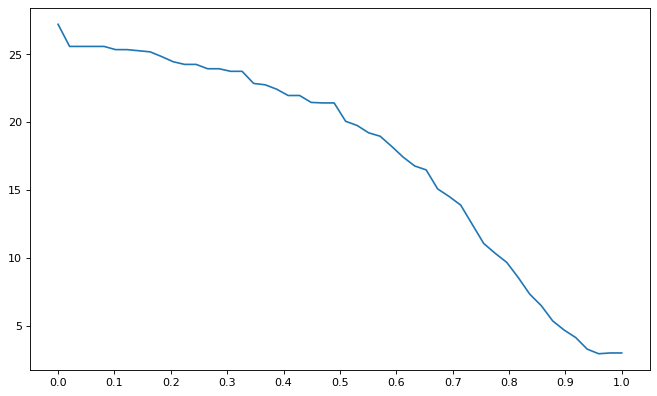

In [15]:
x = res["threshold_levels"]
y = res["agreement_wers"]

plt.figure(figsize=(10, 6), dpi=80)

plt.xticks(np.arange(min(x), max(x)+1, 0.1))
plt.plot(x, [yi * 100 for yi in y ])

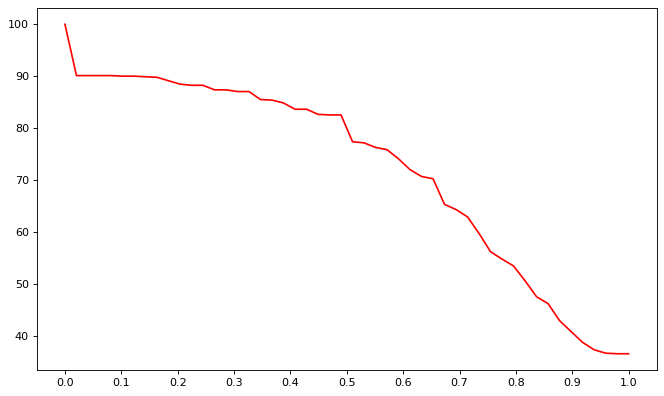

In [16]:
#fig, ax1 = plt.subplots()

#ax2 = ax1.twinx()
#ax2.set_ylim(0,100)
x = res["threshold_levels"]
y = res["agreement_ratios"]

plt.figure(figsize=(10, 6), dpi=80)

plt.xticks(np.arange(min(x), max(x)+1, 0.1))
plt.plot(x, [yi * 100 for yi in y ], "r")
#ax2.plot(res["threshold_levels"], [x * 100 for x in res["agreement_ratios"]], "r")
#plt.plot(res["threshold_levels"], [x * 10 for x in res["ensemble_wers"]])

## Pairwise evaluation

Here we test KB and Google, calculating their WERs under different scenarios (words, phoneme_words, singular phonemes) and also statistics percentages about 
agreement, overlap and mean-lcs

In [78]:
experiment = meval
_filter = {
    "agreement" : False,
    "g_correct" : False,
    "kb_correct" : False,
}
kwargs = {
    "_filter": None, 
    "phoneme_words" : False,
    "singular_phonemes" : False,
    "preprocess_hook" : None,
    "stress_marks" : True
}
res = experiment_repeats(experiment, 5, bunches, "./models/deep-phonemizer-se.pt", **kwargs)
print_experiment_report(res)

  0%|          | 0/5 [00:00<?, ?it/s]

agreement: 0.44250093040565686±0.0
g_correct_kb_not : 0.24632843791722298±0.0
kb_correct_g_not : 0.3704939919893191±0.0
agreement_not_correct: 0.028595458368376788±0.0
both_incorrect_disagreement: 0.38317757009345793±0.0
google_wer: 0.13522388059701493±0.0
kb_wer: 0.08686567164179104±0.0
google-avg-length: 7.212132489765538±0.0
correct-avg-length: 7.480461481205806±0.0
kb-avg-length: 7.477112020841087±0.0
lcs-mean: 0.8311098882842709±0.0
error_index_overlap: 0.1622994652406417±0.0


## The Google Shortening Detector 

Google's ASR sometimes outputs nothing especially at the start of sentences. Try detecting that by comparing the sequences of vowels

In [133]:
vowels = set("aeiouåäö")
def the_shortening_happened(bunch, threshold):
    numbers = set("0123456789")
    if len(bunch["google"]) > len(bunch["kb"]):
        return False
    for x in bunch["google"]:
        if x in numbers:
            return False
    google_out = [x for x in bunch["google"] if x in vowels]
    kb_out = [x for x in bunch["kb"] if x in vowels]
    score = SequenceMatcher(None, google_out, kb_out).ratio()
    return score < threshold and score > 0.2
    
bunch_list = [{k: bunches[k][i] for k in bunches} for i in range(len([x for x in bunches.values()][0]))]
sorted_bunch_list = [x for x in bunch_list if the_shortening_happened(x, 0.6)]


In [134]:
print("Length of the bunch list" , len(bunch_list))
print("Shortened bunches" ,  len(sorted_bunch_list))
print("The shortening percentage: ", len(sorted_bunch_list) / len(bunch_list))

Length of the bunch list 911
Shortened bunches 18
The shortening percentage:  0.019758507135016465


In [135]:
sorted_bunch_list

[{'google': 'var en bra roll för',
  'correct': 'var den bra då i alla fall',
  'kb': 'var de en bra rål fall'},
 {'google': 'eller',
  'correct': 'oj då såg ni alla i går eller',
  'kb': 'ojdå såg ni alla higår eller'},
 {'google': 'djävulen', 'correct': 'är väl en', 'kb': 'a är vä en'},
 {'google': 'bra det där',
  'correct': 'kanske blir rätt så bra det där och',
  'kb': 'så blir rett så bra det där och'},
 {'google': 'faktiskt',
  'correct': 'det är det faktiskt',
  'kb': 'det är det faktiskt'},
 {'google': 'förslag på',
  'correct': 'dom är vi uschliga på',
  'kb': 'de är vi uörsliga på'},
 {'google': 'så att i så fall är',
  'correct': 'undrar om det kan ha vart så att i så fall är',
  'kb': 'vi undra om det kan ha vart så att det i så fall är'},
 {'google': 'nej precis',
  'correct': 'nej det var kanske på slutet precis',
  'kb': 'nej det var kanske på slutet precis'},
 {'google': 'nej', 'correct': 'nä det förs', 'kb': 'nä det först'},
 {'google': 'kanske någon annan ensam blå',

In [129]:
random.sample(sorted_bunch_list, k=5)

[{'google': 'oj då', 'correct': 'oj då', 'kb': 'åjda'},
 {'google': 'det är liksom', 'correct': 'det är liksom', 'kb': 'da r liksom'},
 {'google': 'nej', 'correct': 'nä det förs', 'kb': 'nä det först'},
 {'google': 'den där',
  'correct': 'till exempel den dära',
  'kb': 'ill exempel den dära'},
 {'google': 'ja det är inte',
  'correct': 'ja ja det ser inte',
  'kb': 'ja ja dent'}]

# Error analysis

### Sort sentences based on WER  

In [42]:
def bunch_normalized_wer(bunch, model):
    return wer(bunch["correct"], bunch[model]) * len(bunch["correct"].split())

def metric(x):
    return bunch_normalized_wer(x,"google")

bunch_list = [{k: bunches[k][i] for k in bunches} for i in range(len([x for x in bunches.values()][0]))]


for bunch in bunch_list:
    bunch["ensemble"] = get_ensemble_output(bunch, None, 0.6, use_phonemizer=False) 
    
sorted_bunch_list = sorted(bunch_list, key=lambda x : metric(x))
sorted_bunch_list.reverse()

In [43]:
wer_sums =  { k : sum(bunch_normalized_wer(x,k) for x in bunch_list) for k in bunch_list[0]}

In [44]:
wer_sums

{'google': 2718.0, 'correct': 0.0, 'kb': 1746.0, 'ensemble': 1805.0}

In [47]:
cbunch = sorted_bunch_list[2]
cbunch
curr_wers = {k : bunch_normalized_wer(cbunch,k) for k,v in cbunch.items()}
curr_wers

{'google': 'en riktigt dålig ser jag 111 234 345 456',
 'correct': 'en riktigt dålig ser jag ett elva två tretti fyra tre fyrtio fem fyra femti sex',
 'kb': 'en riktigt dålig serjag ett elva två trettiofyra tre fyrtiofem fyrafemtiosex',
 'ensemble': 'en riktigt dålig serjag ett elva två trettiofyra tre fyrtiofem fyrafemtiosex'}

{'google': 11.0, 'correct': 0.0, 'kb': 9.0, 'ensemble': 9.0}

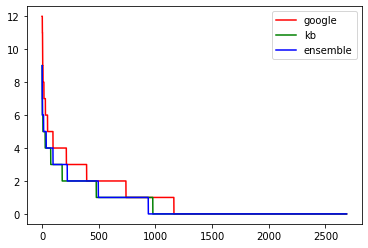

In [84]:
ls = []
models = ["google", "kb", "ensemble"]
for model in models:
    l = []
    sorted_bunch_list = sorted(bunch_list, key=lambda x : bunch_normalized_wer(x,model))
    sorted_bunch_list.reverse()
    for x in sorted_bunch_list:
        curr_wers = {k : bunch_normalized_wer(x,k) for k,v in x.items()}
        l.append(curr_wers[model])
    ls.append(l)
    
labels = models
colors = "rgb"

for i, l in enumerate(ls):
    plt.plot(l, colors[i], label=labels[i])
    plt.legend()

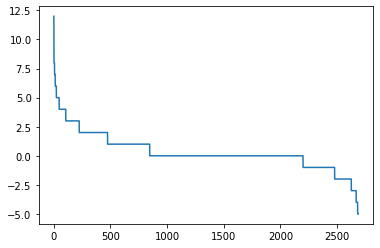

In [105]:
l = []
model = "google"
sorted_bunch_list = sorted(bunch_list, key=lambda x : bunch_normalized_wer(x,"google") - bunch_normalized_wer(x,"kb"))
sorted_bunch_list.reverse()
for x in sorted_bunch_list:
    l.append(bunch_normalized_wer(x,"google") - bunch_normalized_wer(x,"kb"))
plt.plot(l)

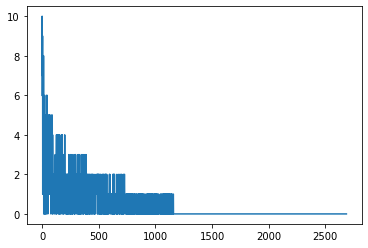

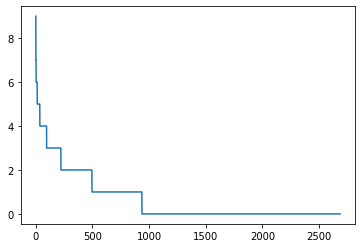

In [38]:
plt.plot(l)

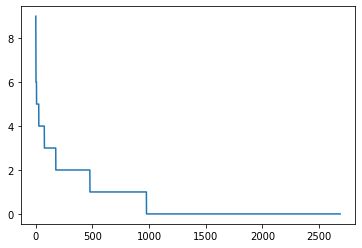

In [36]:
plt.plot(l)

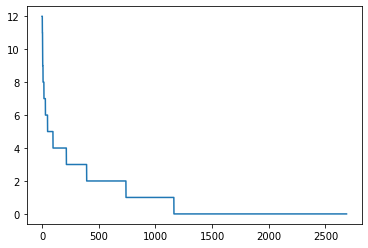

In [34]:
plt.plot(l)

In [7]:
get_kb_google_unmatched_blocks(cbunch)

[('det', 'nego'),
 ('johan sådär', 'är ju han så där att'),
 ('jag hoppas inte', 'ju han på sånt där'),
 ('isolera du', 'isolerade och'),
 ('det', '')]

# Visualization

In [ ]:
idx = 43
size = 10
def get_triad(idx, bunch):
    #### Google, correct, Kb
    return bunch[0][idx], bunch[1][idx], bunch[2][idx]

def plot_triad(triad,ax):
    ax.text(0.0, 0.0, triad[0], size=size, rotation=0,
             ha="center", va="center",
             bbox=dict(boxstyle="round",
                       ec=(1., 0.5, 0.5),
                       fc=(1., 0.8, 0.8),
                       )
             )

    ax.text(0, -2.5,  triad[2], size=size, rotation=0,
             ha="center", va="center",
             bbox=dict(boxstyle="round",
                       ec=(153/255, 51/255, 0/255),
                       fc=(255/255, 153/255, 102/255),
                       )
             )
    ax.text(0, -5,  triad[1], size=size, rotation=0,
             ha="center", va="center",
             bbox=dict(boxstyle="round",
                       ec=(42 / 255, 162 / 255, 42 / 255),
                       fc=(133 / 255, 224 / 255, 133 / 255),
                       )
             )
    
    ax.set_ylim(-10, 10)
    ax.set_xlim(-10, 10)

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))
idx = 0
plot_triad(get_triad(idx, text_data_bunch) ,axs[0])
plot_triad(get_triad(idx, phoneme_data_bunch) ,axs[1])

In [ ]:

def print_triad_correctness(triad):
    #### Google, correct, Kb
    print("Google correct ", triad[1] == triad[0])
    print("KB correct ", triad[1] == triad[2])
    print("Agreement ", triad[0] == triad[2])
    
    print("Google WER ", wer(triad[1], triad[0]))
    print("KB WER ", wer(triad[1], triad[2]))